<a href="https://colab.research.google.com/github/alinzer/Penzai-few-shot/blob/main/Penzai_spiral_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import and setup Penzai

In [ ]:
try:
  import penzai
except ImportError:
  !pip install penzai[notebook]

In [ ]:
import time

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [ ]:
%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import penzai
from penzai import pz
from penzai.models import simple_mlp

In [ ]:
pz.ts.basic_interactive_setup()
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

# Optional: enables automatic array visualization
pz.ts.active_autovisualizer.set_interactive(pz.ts.ArrayAutovisualizer())

# Generate and plot data


In [ ]:
# Generate spiral dataset
# Adapted from https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5
def generate_spiral_dataset(key=0, num_per_class=250, zero_var=1., one_var=1., shuffle=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key1, key2, key3, key4 = jr.split(key, 4)

    theta = jnp.sqrt(jr.uniform(key1, shape=(num_per_class,))) * 2*jnp.pi
    r = 2*theta + jnp.pi
    generate_data = lambda theta, r: jnp.array([jnp.cos(theta)*r, jnp.sin(theta)*r]).T

    # Data for output zero
    zero_input = generate_data(theta, r) + zero_var * jr.normal(key2, shape=(num_per_class, 2))
    zero_output = jnp.zeros((num_per_class, 1,))

    # Data for output one
    one_input = generate_data(theta, -r) + one_var * jr.normal(key3, shape=(num_per_class, 2))
    one_output = jnp.ones((num_per_class, 1,))

    # Stack the inputs and standardize
    input = jnp.concatenate([zero_input, one_input])
    input = (input - input.mean(axis=0)) / input.std(axis=0)

    # Generate binary output
    output = jnp.concatenate([jnp.zeros(num_per_class), jnp.ones(num_per_class)])

    if shuffle:
        idx = jr.permutation(key4, jnp.arange(num_per_class * 2))
        input, output = input[idx], output[idx]

    return input, output

In [ ]:
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split # For splitting the data

In [ ]:
# Helper function that visualizes 2d posterior predictive distribution
def plot_posterior_predictive(ax, X, Y, title, Xspace=None, Zspace=None, cmap=cm.rainbow):
    if Xspace is not None and Zspace is not None:
        ax.contourf(*(Xspace.T), (Zspace.T[0]), cmap=cmap, levels=50)
        ax.axis('off')
    colors = ['red' if y else 'blue' for y in Y]
    ax.scatter(*X.T, c=colors, edgecolors='black', s=50)
    ax.set_title(title)
    return ax

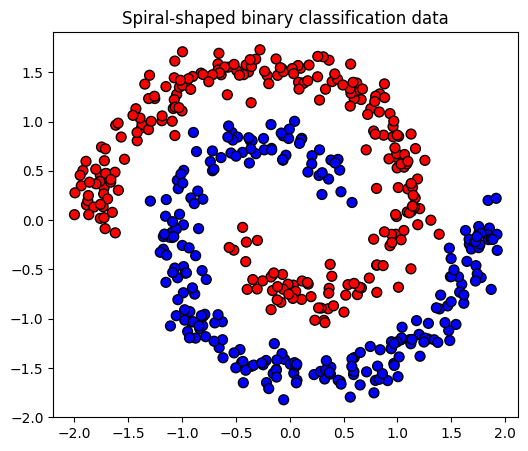

In [ ]:
# Generate data
X, y = generate_spiral_dataset()

# Plot data
fig, ax = plt.subplots(figsize=(6, 5))

title = "Spiral-shaped binary classification data"
plot_posterior_predictive(ax, X, y, title);

In [ ]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
example_inputs_train = pz.nx.wrap(X_train).tag("examples", "features")
example_targets_train = pz.nx.wrap(y_train).tag("examples")
example_inputs_val = pz.nx.wrap(X_val).tag("examples", "features")
example_targets_val = pz.nx.wrap(y_val).tag("examples")

#SGD

In [ ]:
# Set up MLP
mlp = simple_mlp.MLP.from_config(
    name="mlp",
    init_base_rng=jax.random.key(0),
    feature_sizes=[2,16,16,1]
)

In [ ]:
#Simple training loop
from penzai.toolshed import basic_training
import optax
import shutil
import os

In [ ]:
# Clear the log directory
log_dir = 'logs'
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

# Set up TensorBoard
# writer = SummaryWriter(log_dir=log_dir)

In [ ]:
def loss_fn(model, rng, state, data):
  current_input_train, current_target_train, current_input_val, current_target_val = data['input_train'], data['target_train'], data['input_val'], data['target_val']
  del rng, state  # More complex training loops could use these if needed

  model_out_train = pz.nx.nmap(jax.nn.sigmoid)(model(current_input_train))
  losses_train = pz.nx.nmap(optax.sigmoid_binary_cross_entropy)(model_out_train, current_target_train)
  loss_train = losses_train.untag("examples", "features").unwrap().mean()

  model_pred_train = pz.nx.nmap(jnp.where)(model_out_train > 0.5, 1, 0)
  accuracies_train = pz.nx.nmap(jnp.equal)(model_pred_train, current_target_train)
  acc_train = accuracies_train.untag("examples", "features").unwrap().mean()

  model_out_val = pz.nx.nmap(jax.nn.sigmoid)(model(current_input_val))
  losses_val = pz.nx.nmap(optax.sigmoid_binary_cross_entropy)(model_out_val, current_target_val)
  loss_val = losses_val.untag("examples", "features").unwrap().mean()

  model_pred_val = pz.nx.nmap(jnp.where)(model_out_val > 0.5, 1, 0)
  accuracies_val = pz.nx.nmap(jnp.equal)(model_pred_val, current_target_val)
  acc_val = accuracies_val.untag("examples", "features").unwrap().mean()

  return (loss_train, None, {"my_loss_train": loss_train, "my_acc_train": acc_train, "my_loss_val": loss_val, "my_acc_val": acc_val})


In [ ]:
# best_val_loss = np.inf
# patience = 10  # Number of epochs to wait if validation loss doesn't improve by the required percentage
# percent_change_threshold = 0.01  # 1% change
# wait = 0
# previous_val_loss = best_val_loss

# def loss_fn(model, rng, state, data):
#   current_input_train, current_target_train, current_input_val, current_target_val = data['input_train'], data['target_train'], data['input_val'], data['target_val']
#   del rng, state  # More complex training loops could use these if needed

#   model_out_train = pz.nx.nmap(jax.nn.sigmoid)(model(current_input_train))
#   losses_train = pz.nx.nmap(optax.sigmoid_binary_cross_entropy)(model_out_train, current_target_train)
#   loss_train = losses_train.untag("examples", "features").unwrap().mean()

#   model_pred_train = pz.nx.nmap(jnp.where)(model_out_train > 0.5, 1, 0)
#   accuracies_train = pz.nx.nmap(jnp.equal)(model_pred_train, current_target_train)
#   acc_train = accuracies_train.untag("examples", "features").unwrap().mean()

#   model_out_val = pz.nx.nmap(jax.nn.sigmoid)(model(current_input_val))
#   losses_val = pz.nx.nmap(optax.sigmoid_binary_cross_entropy)(model_out_val, current_target_val)
#   loss_val = losses_val.untag("examples", "features").unwrap().mean()

#   model_pred_val = pz.nx.nmap(jnp.where)(model_out_val > 0.5, 1, 0)
#   accuracies_val = pz.nx.nmap(jnp.equal)(model_pred_val, current_target_val)
#   acc_val = accuracies_val.untag("examples", "features").unwrap().mean()

#   return (loss_train, None, {"my_loss_train": loss_train, "my_acc_train": acc_train, "my_loss_val": loss_val, "my_acc_val": acc_val})


# # trainer = basic_training.StatefulTrainer.build(
# #     root_rng=jax.random.key(42),
# #     model=mlp,
# #     optimizer_def=optax.adam(0.05),
# #     loss_fn=loss_fn,
# # )

# outputs = []
# percent_changes = []
# # while trainer.state.value.step < 2000:
# #     out_train = trainer.step(
# #         data = {'input_train':example_inputs_train,'target_train':example_targets_train,'input_val':example_inputs_val,'target_val':example_targets_val}
# #     )

# #     # Log metrics to TensorBoard
# #     step = trainer.state.value.step
# #     writer.add_scalar('Loss/train', out_train['my_loss_train'].item(), step)
# #     writer.add_scalar('Accuracy/train', out_train['my_acc_train'].item(), step)
# #     writer.add_scalar('Loss/val', out_train['my_loss_val'].item(), step)
# #     writer.add_scalar('Accuracy/val', out_train['my_acc_val'].item(), step)

# #     # Early stopping logic
# #     if previous_val_loss != np.inf:
# #         percent_change = abs((previous_val_loss - out_train['my_loss_val']) / previous_val_loss)

# #         if percent_change < percent_change_threshold:
# #             wait += 1
# #         else:
# #             wait = 0

# #         if wait >= patience:
# #             print(f"Stopping early at step {step} due to no significant improvement in validation loss.")
# #             break

# #     if out_train['my_loss_val'] < best_val_loss:
# #         best_val_loss = out_train['my_loss_val']

# #     previous_val_loss = out_train['my_loss_val']
# #     outputs.append(out_train)

# # Close TensorBoard writer
# # writer.close()

In [ ]:
# Define grid limits
xmin, ymin = X.min(axis=0) - 0.1
xmax, ymax = X.max(axis=0) + 0.1

# Define grid
step = 0.1
x_grid, y_grid = jnp.mgrid[xmin:xmax:step, ymin:ymax:step]
# Create input grid by stacking x_grid and y_grid
input_grid = jnp.stack([x_grid, y_grid], axis=-1)
# Flatten the input grid for prediction
flat_input_grid = input_grid.reshape(-1, 2)
flat_input_grid = pz.nx.wrap(flat_input_grid).tag("examples", "features")

In [ ]:
# Helper function that visualizes 2d posterior predictive distribution
def plot_posterior_predictive(ax, X, Y, title, Xspace=None, Zspace=None, cmap=cm.rainbow):
    if Xspace is not None and Zspace is not None:
        ax.contourf(*(Xspace.T), (Zspace.T[0]), cmap=cmap, levels=50)
        ax.axis('off')
    colors = ['red' if y else 'blue' for y in Y]
    ax.scatter(*X.T, c=colors, edgecolors='black', s=50)
    ax.set_title(title)
    return ax

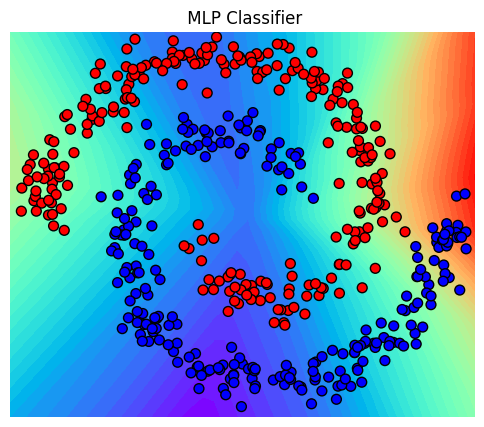

In [ ]:
# Make predictions on the flattened input grid
predictions = mlp(flat_input_grid)
Z = predictions.unwrap('examples','features').reshape(x_grid.shape[0], x_grid.shape[1], 1)

# Plot the final result
fig, ax = plt.subplots(figsize=(6, 5))
title = " MLP Classifier"
plot_posterior_predictive(ax, X, y, title, input_grid, Z);

In [ ]:
# selection = pz.select(mlp).at_pytree_leaves()
# r = selection.get_sequence()
# values = []
# for i in r:
#   value = i.value
#   if 'features_out' in value.named_axes and 'features' in value.named_axes:
#     value = value.unwrap('features_out', 'features').flatten()
#     values.append(value)
#   else:
#     value = value.unwrap('features').flatten()
#     values.append(value)
# values = np.concatenate(xvalues)
# # values


In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir logs

#EKF

In [ ]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax
from functools import partial
from dynamax.generalized_gaussian_ssm import ParamsGGSSM, EKFIntegrals
from dynamax.generalized_gaussian_ssm import conditional_moments_gaussian_filter
from jax.flatten_util import ravel_pytree

In [ ]:
# Function to build new flat params into format that fits old params
def get_new_params(params, flat_params):
  start_index = 0
  for param in params:
    named_shape = param.value.named_shape
    shape = [int(value) for value in named_shape.values()]
    num = np.prod(shape)
    flattened_portion = flat_params[start_index:start_index + num]

    reconstructed_array = jnp.reshape(flattened_portion, shape)
    array = pz.nx.wrap(reconstructed_array)
    if len(shape) == 1:
      array = array.tag("features")
    else:
      array = array.tag("features", "features_out")
    param.value = array
    start_index += num
  return params

In [ ]:
# Set up MLP
def make_mlp():
  mlp = simple_mlp.MLP.from_config(
      name="mlp",
      init_base_rng=jax.random.key(0),
      feature_sizes=[2, 16,16,1]
  )
  def apply(flat_params, x, mlp):
      param_slot, params = pz.unbind_variables(mlp)
      get_new_params(params, flat_params)
      mlp = pz.bind_variables(mlp, params, allow_unused=True)
      x = pz.nx.wrap(x)
      x = x.tag("features")
      return mlp(x)
  apply_fn = partial(apply, mlp=mlp)
  return mlp, apply_fn

In [ ]:
# Get flat_params for EKF init
mlp, apply_fn = make_mlp()
param_slot, params = pz.unbind_variables(mlp)
flattened_arrays = []
for param in params:
  value = param.value
  if "Linear.weights" in param.label:
    value = value.unwrap("features", "features_out")
  else:
    value = value.unwrap("features")
  flattened_arrays.append(value.ravel())
flat_params = jnp.concatenate(flattened_arrays)

In [ ]:
# Some model parameters and helper funciton
sigmoid_fn = lambda w, x: jax.nn.sigmoid(apply_fn(w, x).unwrap("features"))
state_dim, emission_dim = flat_params.size, 1
initial_sigma2 = .1
dynamic_sigma = 1e-4

# Run CMGF-EKF to train the MLP Classifier
initial_mean=flat_params
initial_covariance=jnp.eye(state_dim) * initial_sigma2
dynamics_function=lambda w, x: w
dynamics_covariance=jnp.eye(state_dim) * dynamic_sigma
emission_mean_function = lambda w, x: sigmoid_fn(w, x)
emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))

cmgf_ekf_params = ParamsGGSSM(
     initial_mean = initial_mean,
    initial_covariance = initial_covariance,
    dynamics_function = dynamics_function,
    dynamics_covariance = dynamics_covariance,
    emission_mean_function = emission_mean_function,
    emission_cov_function = emission_cov_function
)
cmgf_ekf_post = conditional_moments_gaussian_filter(cmgf_ekf_params, EKFIntegrals(), y, inputs=X)

# Extract history of filtered weight values
w_means, w_covs = cmgf_ekf_post.filtered_means, cmgf_ekf_post.filtered_covariances

In [ ]:
# 'binary=True' indicates rounding probabilities to binary outputs
def posterior_predictive_grid(grid, mean, apply, binary=False):
    inferred_fn = lambda x: apply(mean, x)
    fn_vec = jnp.vectorize(inferred_fn, signature='(2)->(3)')
    Z = fn_vec(grid)
    if binary:
        Z = jnp.rint(Z)
    return Z

In [ ]:
# Define grid limits
xmin, ymin = X.min(axis=0) - 0.1
xmax, ymax = X.max(axis=0) + 0.1

# Define grid
step = 0.1
x_grid, y_grid = jnp.meshgrid(jnp.mgrid[xmin:xmax:step], jnp.mgrid[ymin:ymax:step])
input_grid = jnp.concatenate([x_grid[...,None], y_grid[...,None]], axis=2)

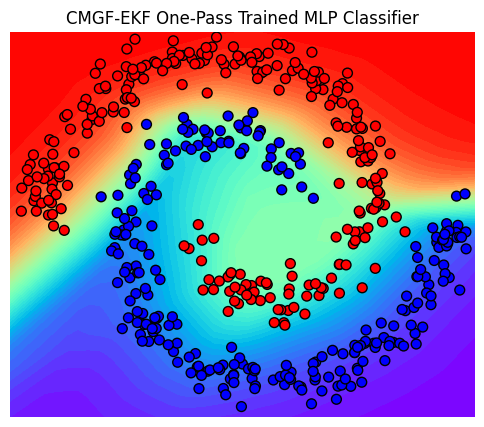

In [ ]:
# Evaluate the trained MLP on input_grid
Z = posterior_predictive_grid(input_grid, w_means[-1], sigmoid_fn, binary=False)
# display(Z)
# Plot the final result
fig, ax = plt.subplots(figsize=(6, 5))
title = "CMGF-EKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X, y, title, input_grid, Z);

In [ ]:
trainer = basic_training.StatefulTrainer.build(
    root_rng=jax.random.key(42),
    model=mlp,
    optimizer_def=optax.adam(0.05),
    loss_fn=loss_fn,
)

outputs = []
while trainer.state.value.step < 1:
    out_train = trainer.step(
        data = {'input_train':example_inputs_train,'target_train':example_targets_train,'input_val':example_inputs_val,'target_val':example_targets_val}
    )

    # Log metrics to TensorBoard
    step = trainer.state.value.step
    # writer.add_scalar('EKF/Loss/train', out_train['my_loss_train'].item(), step)
    # writer.add_scalar('EKF/Accuracy/train', out_train['my_acc_train'].item(), step)
    # writer.add_scalar('EKF/Loss/val', out_train['my_loss_val'].item(), step)
    # writer.add_scalar('EKF/Accuracy/val', out_train['my_acc_val'].item(), step)

    outputs.append(out_train)

# Close TensorBoard writer
# writer.close()

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir logs

#Flax


In [ ]:
# try:
#     import flax.linen as nn
# except ModuleNotFoundError:
#     print('installing flax')
#     %pip install -qq flax
# import flax.linen as nn
# from typing import Sequence

In [ ]:
# class MLP(nn.Module):
#     features: Sequence[int]

#     @nn.compact
#     def __call__(self, x):
#         for feat in self.features[:-1]:
#             x = nn.relu(nn.Dense(feat)(x))
#         x = nn.Dense(self.features[-1])(x)
#         return x

In [ ]:
# def get_mlp_flattened_params(model_dims, key=0):
#     if isinstance(key, int):
#         key = jr.PRNGKey(key)

#     # Define MLP model
#     input_dim, features = model_dims[0], model_dims[1:]
#     model = MLP(features)
#     dummy_input = jnp.ones((input_dim,))
#     # Initialize parameters using dummy input
#     params = model.init(key, dummy_input)

#     flat_params, unflatten_fn = ravel_pytree(params)

#     # Define apply function
#     def apply(flat_params, x, model, unflatten_fn):
#         return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

#     apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

#     return model, flat_params, unflatten_fn, apply_fn

In [ ]:
# # Define MLP architecture
# input_dim, hidden_dims, output_dim = 2, [16, 16], 1
# model_dims = [input_dim, *hidden_dims, output_dim]
# model, flat_params, unflatten_fn, apply_fn = get_mlp_flattened_params(model_dims)

In [ ]:
# # Some model parameters and helper funciton
# state_dim, emission_dim = flat_params.size, output_dim
# sigmoid_fn = lambda w, x: jax.nn.sigmoid(apply_fn(w, x))
# initial_sigma2 = .1
# dynamic_sigma = 1e-4

# # Run CMGF-EKF to train the MLP Classifier
# initial_mean=flat_params
# initial_covariance=jnp.eye(state_dim) * initial_sigma2
# dynamics_function=lambda w, x: w
# dynamics_covariance=jnp.eye(state_dim) * dynamic_sigma
# emission_mean_function = lambda w, x: sigmoid_fn(w, x)
# emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))

# cmgf_ekf_params = ParamsGGSSM(
#      initial_mean = initial_mean,
#     initial_covariance = initial_covariance,
#     dynamics_function = dynamics_function,
#     dynamics_covariance = dynamics_covariance,
#     emission_mean_function = emission_mean_function,
#     emission_cov_function = emission_cov_function
# )
# cmgf_ekf_post = conditional_moments_gaussian_filter(cmgf_ekf_params, EKFIntegrals(), y, inputs=X)

# # Extract history of filtered weight values
# w_means, w_covs = cmgf_ekf_post.filtered_means, cmgf_ekf_post.filtered_covariances

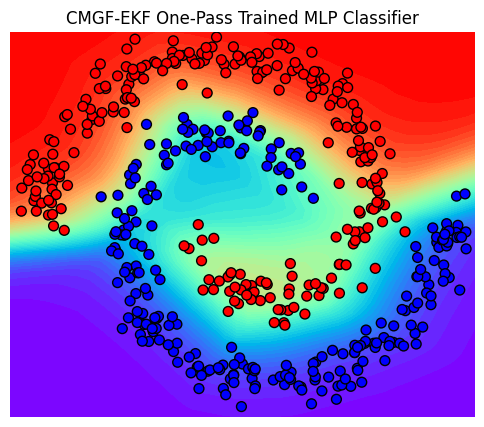

In [ ]:
# # Evaluate the trained MLP on input_grid
# Z = posterior_predictive_grid(input_grid, w_means[-1], sigmoid_fn, binary=False)
# # Plot the final result
# fig, ax = plt.subplots(figsize=(6, 5))
# title = "CMGF-EKF One-Pass Trained MLP Classifier"
# plot_posterior_predictive(ax, X, y, title, input_grid, Z);

In [ ]:
apply_fn(flat_params,jnp.ones(2))

<jax.Array([-0.2424503], dtype=float32)>

#Compare

In [ ]:
# 'binary=True' indicates rounding probabilities to binary outputs
def posterior_predictive_grid(grid, mean, apply, binary=False):
    inferred_fn = lambda x: apply(mean, x)
    fn_vec = jnp.vectorize(inferred_fn, signature='(2)->(3)')
    Z = fn_vec(grid)
    if binary:
        Z = jnp.rint(Z)
    return Z

In [ ]:
# Helper function that visualizes 2d posterior predictive distribution
def plot_posterior_predictive(ax, X, Y, title, Xspace=None, Zspace=None, cmap=cm.rainbow):
    if Xspace is not None and Zspace is not None:
        ax.contourf(*(Xspace.T), (Zspace.T[0]), cmap=cmap, levels=50)
        ax.axis('off')
    colors = ['red' if y else 'blue' for y in Y]
    ax.scatter(*X.T, c=colors, edgecolors='black', s=50)
    ax.set_title(title)
    return ax

In [ ]:
# Define grid limits
xmin, ymin = X.min(axis=0) - 0.1
xmax, ymax = X.max(axis=0) + 0.1

# Define grid
step = 0.1
x_grid, y_grid = jnp.mgrid[xmin:xmax:step, ymin:ymax:step]
# Create input grid by stacking x_grid and y_grid
input_grid = jnp.stack([x_grid, y_grid], axis=-1)
# Flatten the input grid for prediction
flat_input_grid = input_grid.reshape(-1, 2)
flat_input_grid = pz.nx.wrap(flat_input_grid).tag("examples", "features")

In [ ]:
sizes=[4000,8000,12000]

log_dir = 'compare'
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
# Set up TensorBoard
writer = SummaryWriter(log_dir=log_dir)

ekf_times = []
sgd_times = []
i = 1
while i < 2:
  i+=1
  X, y = generate_spiral_dataset(num_per_class=9048)

  # Set up SGD
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
  example_inputs_train = pz.nx.wrap(X_train).tag("examples", "features")
  example_targets_train = pz.nx.wrap(y_train).tag("examples")
  example_inputs_val = pz.nx.wrap(X_val).tag("examples", "features")
  example_targets_val = pz.nx.wrap(y_val).tag("examples")
  sgd_mlp = simple_mlp.MLP.from_config(
    name="mlp",
    init_base_rng=jax.random.key(0),
    feature_sizes=[2,16,16,1]
  )
  trainer = basic_training.StatefulTrainer.build(
    root_rng=jax.random.key(42),
    model=sgd_mlp,
    optimizer_def=optax.adam(0.05),
    loss_fn=loss_fn,
  )
  start_time = time.time()
  while trainer.state.value.step < 2000:
    out_train = trainer.step(
        data = {'input_train':example_inputs_train,'target_train':example_targets_train,'input_val':example_inputs_val,'target_val':example_targets_val}
    )
  end_time = time.time()
  elapsed_time = end_time - start_time
  sgd_times.append(elapsed_time)
  predictions = sgd_mlp(flat_input_grid)
  Z = predictions.unwrap('examples','features').reshape(x_grid.shape[0], x_grid.shape[1], 1)
  plot_posterior_predictive(ax, X, y, title, input_grid, Z);

  # EKF
  ekf_mlp, apply_fn = make_mlp()
  param_slot, params = pz.unbind_variables(ekf_mlp)
  flattened_arrays = []
  for param in params:
    value = param.value
    if "Linear.weights" in param.label:
      value = value.unwrap("features", "features_out")
    else:
      value = value.unwrap("features")
    flattened_arrays.append(value.ravel())
  flat_params = jnp.concatenate(flattened_arrays)
  # Some model parameters and helper funciton
  sigmoid_fn = lambda w, x: jax.nn.sigmoid(apply_fn(w, x).unwrap("features"))
  state_dim, emission_dim = flat_params.size, 1
  initial_sigma2 = .1
  dynamic_sigma = 1e-4

  # Run CMGF-EKF to train the MLP Classifier
  initial_mean=flat_params
  initial_covariance=jnp.eye(state_dim) * initial_sigma2
  dynamics_function=lambda w, x: w
  dynamics_covariance=jnp.eye(state_dim) * dynamic_sigma
  emission_mean_function = lambda w, x: sigmoid_fn(w, x)
  emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))

  cmgf_ekf_params = ParamsGGSSM(
      initial_mean = initial_mean,
      initial_covariance = initial_covariance,
      dynamics_function = dynamics_function,
      dynamics_covariance = dynamics_covariance,
      emission_mean_function = emission_mean_function,
      emission_cov_function = emission_cov_function
  )
  start_time = time.time()
  cmgf_ekf_post = conditional_moments_gaussian_filter(cmgf_ekf_params, EKFIntegrals(), y, inputs=X)
  end_time = time.time()
  elapsed_time = end_time - start_time
  ekf_times.append(elapsed_time)
  # Extract history of filtered weight values
  w_means, w_covs = cmgf_ekf_post.filtered_means, cmgf_ekf_post.filtered_covariances
  # Evaluate the trained MLP on input_grid
  Z = posterior_predictive_grid(input_grid, w_means[-1], sigmoid_fn, binary=False)
  plot_posterior_predictive(ax, X, y, title, input_grid, Z);

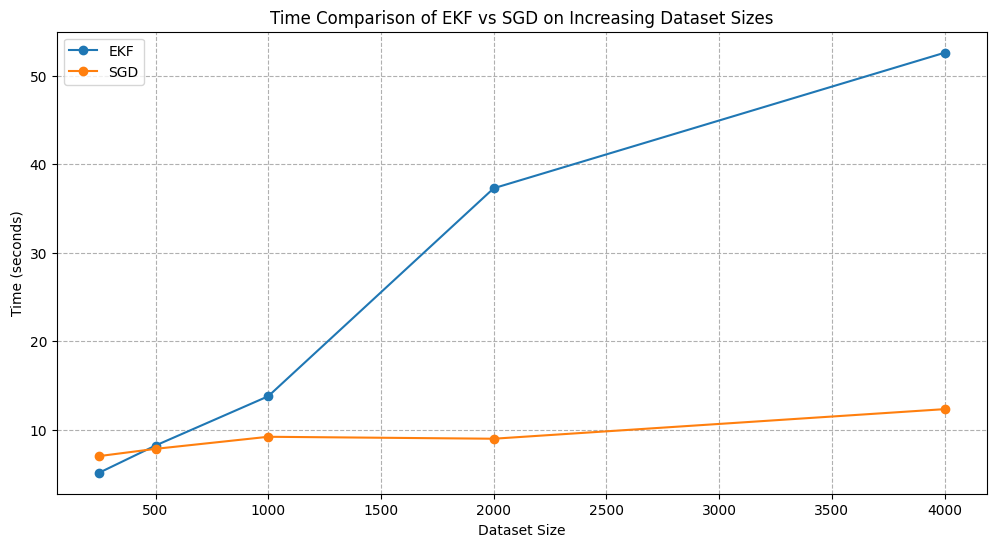

In [ ]:
# Plot the results
sizes=[250,500,1000,2000,4000]
plt.figure(figsize=(12, 6))
plt.plot(sizes, ekf_times, label='EKF', marker='o')
plt.plot(sizes, sgd_times, label='SGD', marker='o')
plt.xlabel('Dataset Size')
plt.ylabel('Time (seconds)')
plt.title('Time Comparison of EKF vs SGD on Increasing Dataset Sizes')
plt.legend()
# plt.xscale('log')  # Use logarithmic scale for better visualization
# plt.yscale('log')  # Use logarithmic scale for better visualization
plt.grid(True, which="both", ls="--")
plt.show()